In [1]:
%config Completer.use_jedi = False

import numpy as np
import matplotlib.pyplot as plt

#import torch
from hummingbird.ml import convert, load #https://github.com/microsoft/hummingbird
# hummingbird is usefull when you have trained model and you need to speed up prediction step
# it doesn't have nmf

from utils import load_file
from utils import DataResize
from utils import DeltaF

### User inputs

In [2]:
# data address
h5_add = 'I:/P6 Project/Analyses/Triple mutation/210127_P6_scn2a_triplet/h5/run3_LED17mA-1h56min small obj.h5'

### Data loading

In [3]:
# load data
data = load_file(add=h5_add, key_name = 'GroupHierarchy.Groups.Datasets')

C:\Users\admin\Documents\Python Scripts\P6 Project\Calcium-imaging-data-analysis\utils.py:97: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  file = h5.File(add)


selected file size: (48000, 256, 256)


### Preprocessing

In [4]:
# resizing data 
data_resized = DataResize(data=data, dim=(128,128)).transform()
print(f'new data size: {data_resized.shape}')

new data size: (48000, 128, 128)


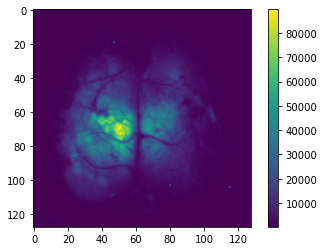

In [9]:
# feature selection

# (1) check variance in the video
plt.imshow(np.var(data_resized, axis=0))
plt.colorbar()

In [35]:
from sklearn.feature_selection import VarianceThreshold

n, p1, p2 = data_resized.shape

# initialize class with user given threshold
var_feature = VarianceThreshold(threshold=50000)

# fit on data
var_feature.fit(data_resized.reshape(n, p1 * p2))

# transform data
feature_selected = var_feature.transform(data_resized.reshape(n, p1 * p2))

print(f'selected feature shape for given threshold: {feature_selected.shape}')

selected feature shape for given threshold: (48000, 211)


In [44]:
# reconstructing back data
data_rec = var_feature.inverse_transform(feature_selected)

# reshape back data to 3d tensor
data_rec = data_rec.reshape(n, p1, p2)

print(f'reconstructed data size: {data_rec.shape} \n\n\n')
print('HINT: PLEASE NOTICE THAT, X with columns of zeros inserted where features would have been removed by transform')

reconstructed data size: (48000, 128, 128)


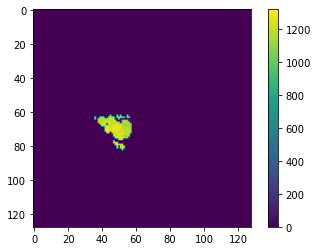

In [46]:
# if 

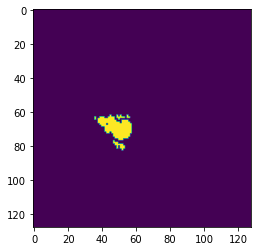

In [43]:
plt.imshow(var_feature.get_support().reshape(p1, p2))

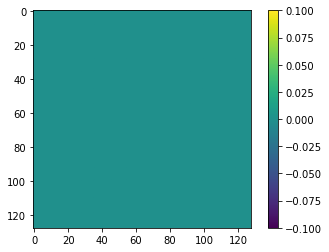

In [37]:
plt.imshow(np.mean(data_rec, axis=0))
plt.colorbar()

In [6]:
# claculate detalf/f0
n, p1, p2 = data_resized.shape
data_deltaf = DeltaF(data=data_resized.reshape(n, p1*p2), prct = 20).run_on_matrix()

100%|████████████████████████████████████| 16384/16384 [04:47<00:00, 56.99it/s]


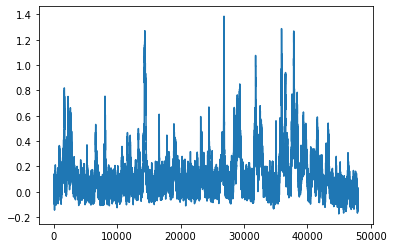